In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pingouin as pg
import statsmodels.api as sm
import bootstrapped as bs
from tqdm.auto import tqdm
from scipy.stats import norm, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
df = pd.read_csv('C:/Users/under/Desktop/karpov_courses/hw_bootstrap.csv', sep=';')

In [3]:
df

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control
...,...,...,...
995,996,1000,Treatment
996,997,1200,Treatment
997,998,1500,Treatment
998,999,2000,Treatment


In [4]:
df.shape

(1000, 3)

In [5]:
df.dtypes

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

Целевые значения в датафрейме типа 'object'. Конвертируем и дополнительно убираем ненужный столбец с нумерацией.

Target values are in 'object' type. Converting to float and dropping column with numeration.

In [6]:
df.value = df.value.str.replace(',', '.')

df.value = df.value.astype('float')

df = df.drop(columns={'Unnamed: 0'})

In [7]:
df.experimentVariant.value_counts()

Control      500
Treatment    500
Name: experimentVariant, dtype: int64

Разделяем основной датафрейм на контрольную и тестовую группы.

Splitting main df to control and test groups.

In [8]:
control_df = df.query('experimentVariant == "Control"')
control_df = control_df.drop(columns={'experimentVariant'})
test_df = df.query('experimentVariant == "Treatment"')
test_df = test_df.drop(columns={'experimentVariant'})

In [9]:
control_df.head()

,value
0,10.380495
1,9.546867
2,11.088215
3,10.147274
4,9.789808


In [10]:
test_df.head()

,value
500,10.380495
501,9.546867
502,11.088215
503,10.147274
504,9.789808


In [100]:
print('Control df shape', control_df.mean())
print('Test df shape', test_df.mean())

Control df shape value    10.026867
dtype: float64
Test df shape value    27.321499
dtype: float64


Проверяем, что никакие данные не были потеряны.

Checking no data had been lost.

In [11]:
print('Control df shape', control_df.shape)
print('Test df shape', test_df.shape)

Control df shape (500, 1)
Test df shape (500, 1)


Graphs

<AxesSubplot:ylabel='Count'>

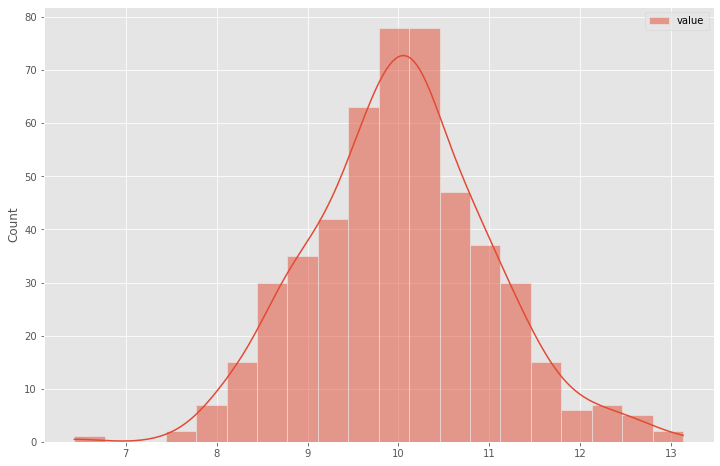

In [43]:
sns.histplot(control_df, bins=20, kde=True)

In [85]:
pg.normality(control_df)

,W,pval,normal
value,0.995925,0.224164,True


<AxesSubplot:ylabel='Count'>

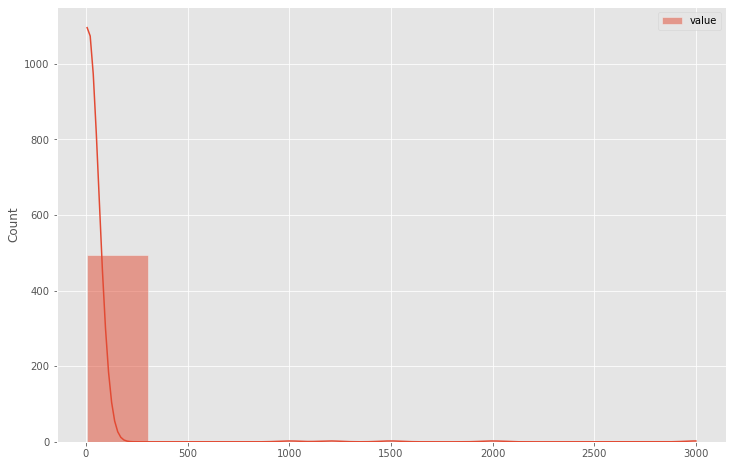

In [44]:
sns.histplot(test_df, bins=10, kde=True)

In [86]:
pg.normality(test_df)

,W,pval,normal
value,0.070389,1.093013e-43,False


Распределение данных в контролной группе можно считать нормальным, распределение тестовой группы скошенно влево и 
является ненормальным по тесту Шапиро-Уилка.

Distribution of values from control group is close to normal, test group distribution bends to the left and considered not-normal due to Shapiro-Wilk test.

____

In [87]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

Бутстрапируем среднее.

Bootstrapping mean.

  0%|          | 0/500 [00:00<?, ?it/s]

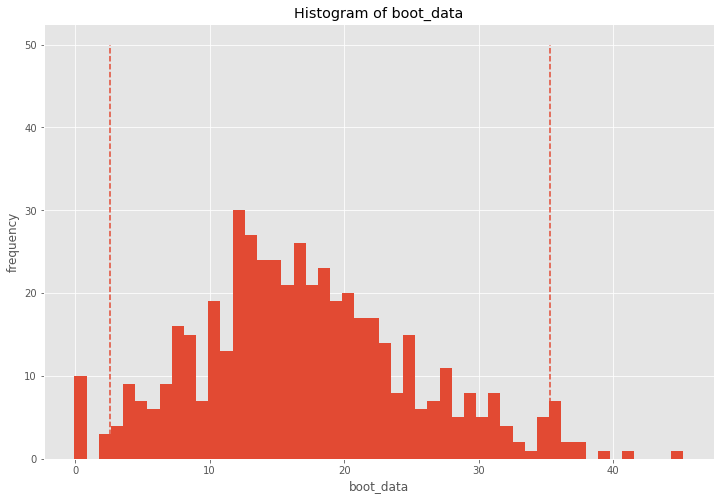

In [88]:
booted_data = get_bootstrap(test_df, control_df, boot_it = 500) # в результате хранится разница двух распределений, ДИ и pvalue

In [91]:
booted_data['p_value']

0.03508719031438957

In [92]:
booted_data['ci']

,0
0.025,2.630722
0.975,35.287492


Бутстрапируем медиану.

Bootstrapping median.

  0%|          | 0/500 [00:00<?, ?it/s]

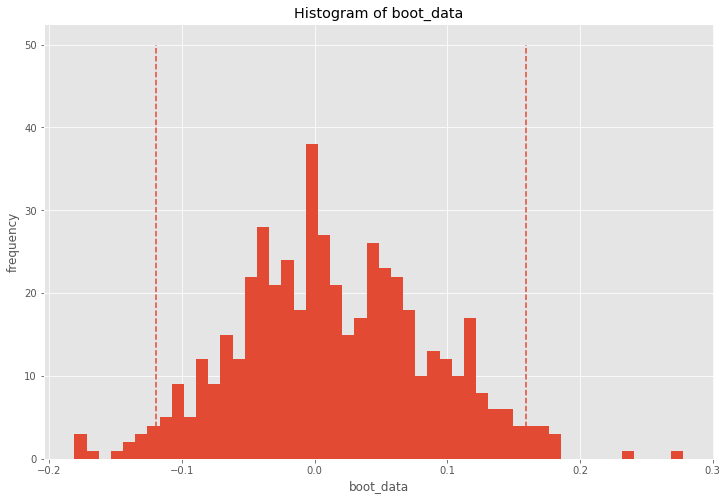

In [93]:
booted_data = get_bootstrap(test_df, control_df, boot_it = 500, statistic=np.median)

In [94]:
booted_data['p_value']

0.8354141299574894

In [95]:
booted_data['ci']

,0
0.025,-0.119408
0.975,0.159420


Критерий Манна-Уитни.

Mann-Whitney test.

In [102]:
pg.mwu(test_df, control_df, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,125810.5,two-sided,0.859215,-0.006484,0.503242


По итогам анализа p-value ниже порогового 0.05 дало только бутсрапирование среднего значения. Критерий Манна-Уитни и
бутстрап медианы дали крайне высокиий p-value.

In [ ]:
#####################################################

<AxesSubplot:>

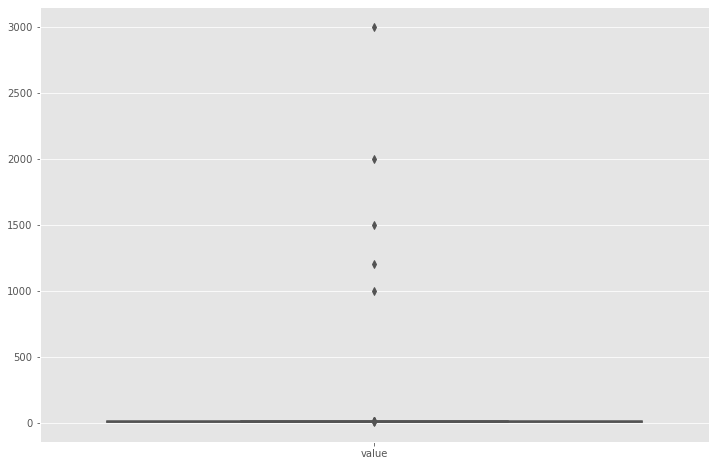

In [51]:
# График тестового датасета
sns.boxplot(data=test_df)

<AxesSubplot:>

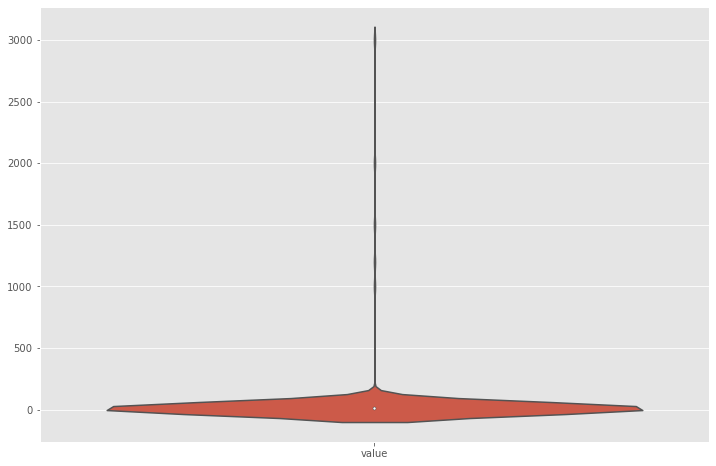

In [116]:
# Более наглядный график тестового датасета
sns.violinplot(data=test_df)

<AxesSubplot:>

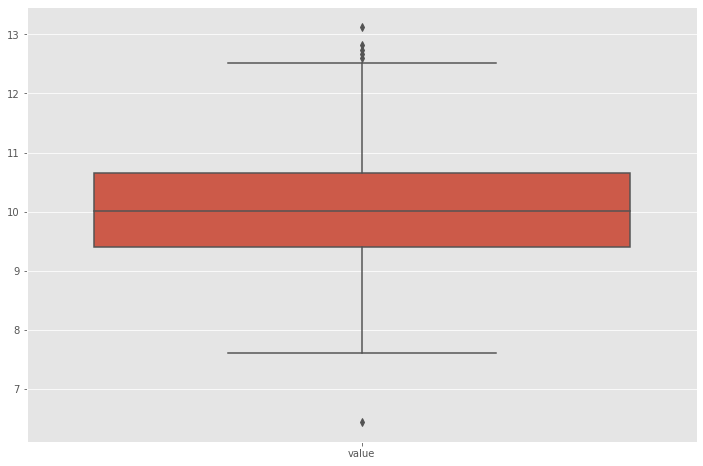

In [52]:
# График тестового датасета без значений превышающих 500
sns.boxplot(data=test_df.query('value < 500'))

<AxesSubplot:>

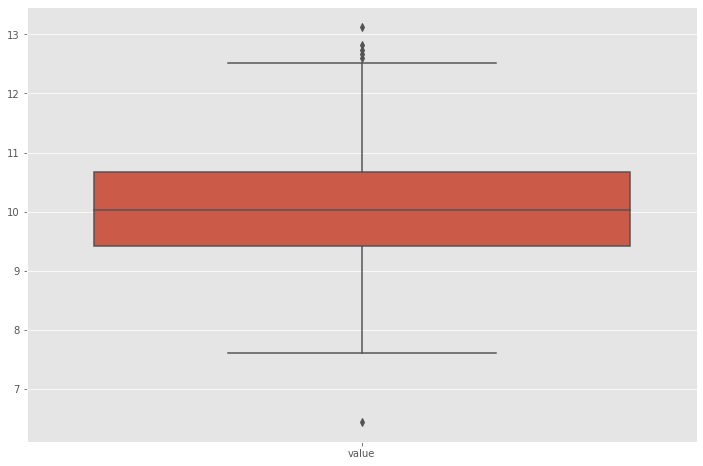

In [53]:
# График контрольного датасета
sns.boxplot(data=control_df)

In [119]:
test_df.value.round().value_counts()

10.0      213
9.0       113
11.0      109
12.0       28
8.0        25
13.0        6
1000.0      1
1500.0      1
2000.0      1
1200.0      1
3000.0      1
6.0         1
Name: value, dtype: int64

Низкое значение p-value при бутстрапировани среднего в большей степени обусловлено сильными выбросами в тестовой выборке, которые сильно завышают среднее значние.
Критерий Манна-Уитни и использование в бутстрапе медианы значительно уменьшает влияние выбросов на итоговый p-value.
В целом эти 2 метода хорошо подходят для решения данной задачи, однако предпочтение я отдаю бутстрапу медианы, так как ее результат проще интпретировать.

Вывод - мы оставляем нулевую гипотезу, различия между контрольной и тестовой группой не являются статистически значимыми.

_____

Ниже небольшой тест бутстрапа на возможность случайной ошибки.

Бутстрап среднего значения в одном случае дал p-value больше 0.05.

Бутстрап медианы ни разу не дал p-value ниже 0.05.

In [104]:
def get_bootstrap_0(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:xlabel='index', ylabel='0'>

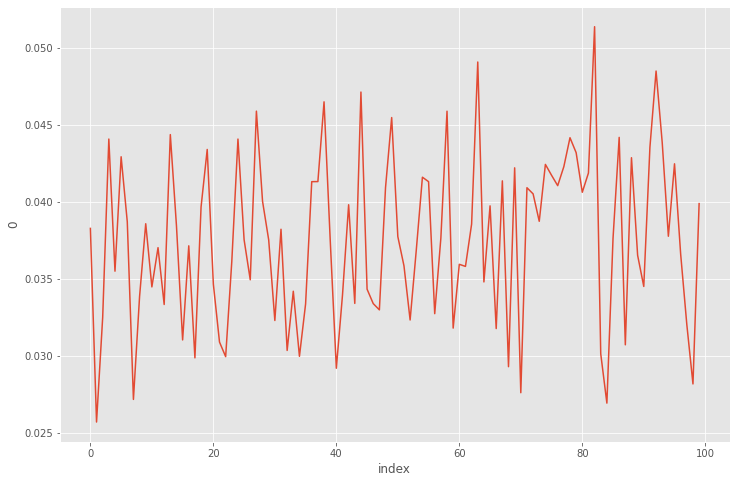

In [135]:
l = []
for i in tqdm(range(100)):
    l.append(get_bootstrap_0(test_df, control_df, boot_it = 500, statistic=np.mean)['p_value'])
l = pd.DataFrame(l).reset_index()
sns.lineplot(y=0, x='index', data=l)

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:xlabel='index', ylabel='0'>

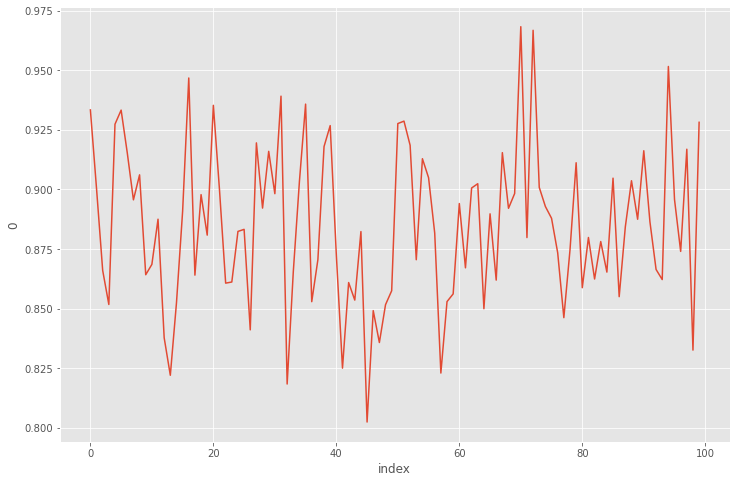

In [136]:
l = []
for i in tqdm(range(100)):
    l.append(get_bootstrap_0(test_df, control_df, boot_it = 500, statistic=np.median)['p_value'])
l = pd.DataFrame(l).reset_index()
sns.lineplot(y=0, x='index', data=l)